In [ ]:
DBFILE = "allblocks-geth-clique-2s-gas40mio-RPC_run1.db" 
NAME_PREFIX="geth-clique-2s-gas40mio-RPC"

# analyze `....db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>20000 transactions shot at a node</a>
# my own experiment: 
## 20000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-geth-clique-2s-gas40mio-RPC_run1.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 92 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 91)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 92


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 91.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 115721
txcount_max 805
txcount_av 217.40217391304347
txcount_sum 20001
blocks_nonempty_count 34
av tx per nonempty blocks =  588.2647058823529


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,1519320357,647,0,40000000,0
1,1,1534777446,607,0,39960939,0
2,2,1534777455,607,0,39921916,0
3,3,1534777500,607,0,39882931,0
4,4,1534777502,607,0,39843984,0
5,5,1534777504,607,0,39805075,0
6,6,1534777506,607,0,39766204,0
7,7,1534777508,607,0,39727371,0
8,8,1534777510,607,0,39688576,0
9,9,1534777512,607,0,39649819,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
23,23,1534777540,115721,21486255,39134415,805,2.0,402.5,232.333333,139.5,69.75,10743127.5,6203709.0,3734942.7,19567207.5,1.957865e+07,19596218.4
30,30,1534777554,105713,19617885,39063372,735,2.0,367.5,357.833333,355.4,317.20,9808942.5,9550929.5,9485981.4,19531686.0,1.953701e+07,19542277.9
36,36,1534777566,105140,19511121,39001278,731,2.0,365.5,356.833333,353.5,355.80,9755560.5,9524238.5,9435268.5,19500639.0,1.950580e+07,19511102.9
41,41,1534777576,104854,19457739,38948458,729,2.0,364.5,356.500000,351.5,352.50,9728869.5,9515341.5,9381886.5,19474229.0,1.947935e+07,19484817.5
33,33,1534777560,104285,19350975,39032122,725,2.0,362.5,352.833333,355.1,353.35,9675487.5,9417474.5,9477974.1,19516061.0,1.952170e+07,19526775.0
40,40,1534777574,104136,19324284,38958195,724,2.0,362.0,350.833333,351.7,352.20,9662142.0,9364092.5,9387224.7,19479097.5,1.948466e+07,19490099.5
31,31,1534777556,103997,19297593,39053963,723,2.0,361.5,359.500000,358.1,353.35,9648796.5,9595414.5,9558047.1,19526981.5,1.953192e+07,19537089.6
35,35,1534777564,103710,19244211,39011184,721,2.0,360.5,355.833333,352.7,354.05,9622105.5,9497547.5,9413915.7,19505592.0,1.951094e+07,19516371.4
28,28,1534777550,102569,19030683,39084491,713,2.0,356.5,353.333333,351.6,245.55,9515341.5,9430820.0,9384555.6,19542245.5,1.954753e+07,19552943.9
27,27,1534777548,102277,18977301,39094870,711,2.0,355.5,351.666667,360.8,209.90,9488650.5,9386335.0,9630112.8,19547435.0,1.955288e+07,19557936.3


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
32,32,1534777558,96273,17856279,39044093,669,2.0,334.5,354.500000,353.9,357.35,8928139.5,9461959.5,9445944.9,19522046.5,1.952690e+07,19532011.9
36,36,1534777566,105140,19511121,39001278,731,2.0,365.5,356.833333,353.5,355.80,9755560.5,9524238.5,9435268.5,19500639.0,1.950580e+07,19511102.9
37,37,1534777568,97984,18176571,38991772,681,2.0,340.5,355.500000,354.7,354.30,9088285.5,9488650.5,9467297.7,19495886.0,1.950071e+07,19505870.8
35,35,1534777564,103710,19244211,39011184,721,2.0,360.5,355.833333,352.7,354.05,9622105.5,9497547.5,9413915.7,19505592.0,1.951094e+07,19516371.4
38,38,1534777570,99993,18550245,38980321,695,2.0,347.5,351.166667,351.7,353.40,9275122.5,9372989.5,9387224.7,19490160.5,1.949556e+07,19500690.7
33,33,1534777560,104285,19350975,39032122,725,2.0,362.5,352.833333,355.1,353.35,9675487.5,9417474.5,9477974.1,19516061.0,1.952170e+07,19526775.0
31,31,1534777556,103997,19297593,39053963,723,2.0,361.5,359.500000,358.1,353.35,9648796.5,9595414.5,9558047.1,19526981.5,1.953192e+07,19537089.6
34,34,1534777562,99136,18390099,39022352,689,2.0,344.5,347.166667,354.1,353.15,9195049.5,9266225.5,9451283.1,19511176.0,1.951643e+07,19521590.2
39,39,1534777572,98702,18310026,38969429,686,2.0,343.0,343.666667,351.4,352.75,9155013.0,9172807.0,9379217.4,19484714.5,1.949025e+07,19495398.4
41,41,1534777576,104854,19457739,38948458,729,2.0,364.5,356.500000,351.5,352.50,9728869.5,9515341.5,9381886.5,19474229.0,1.947935e+07,19484817.5


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


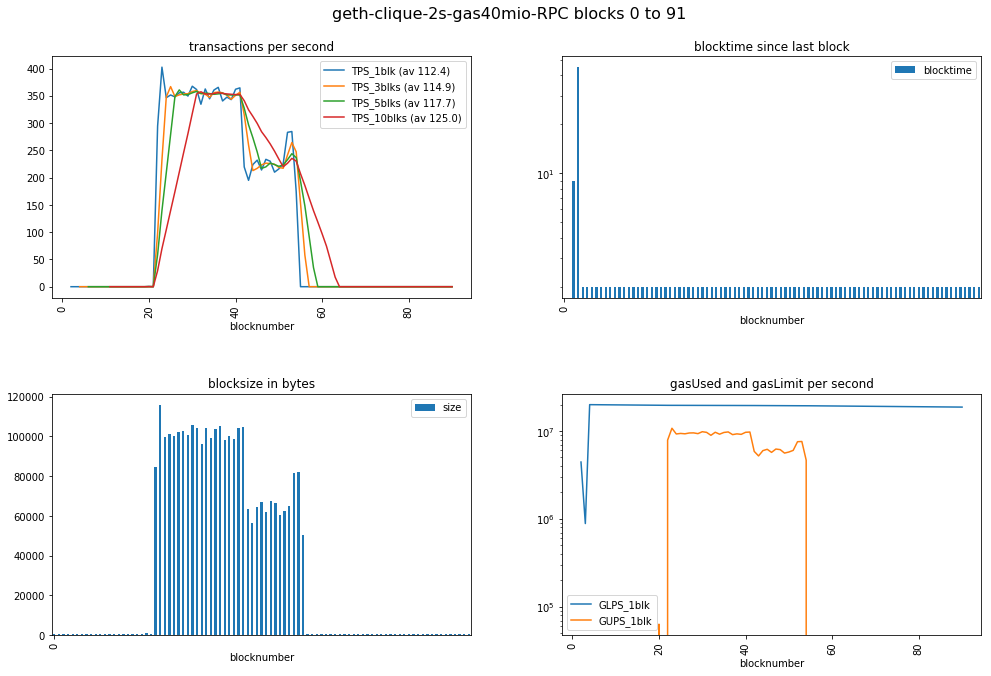

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# final experiment ...


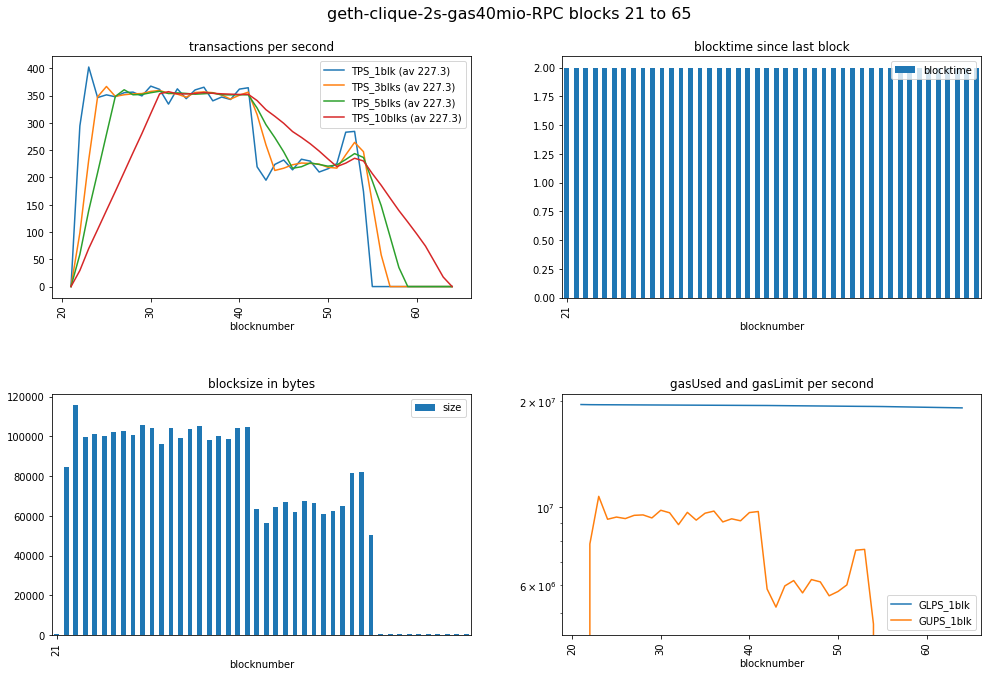

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 21, 65, NAME_PREFIX, gas_logy=True, bt_logy=False)

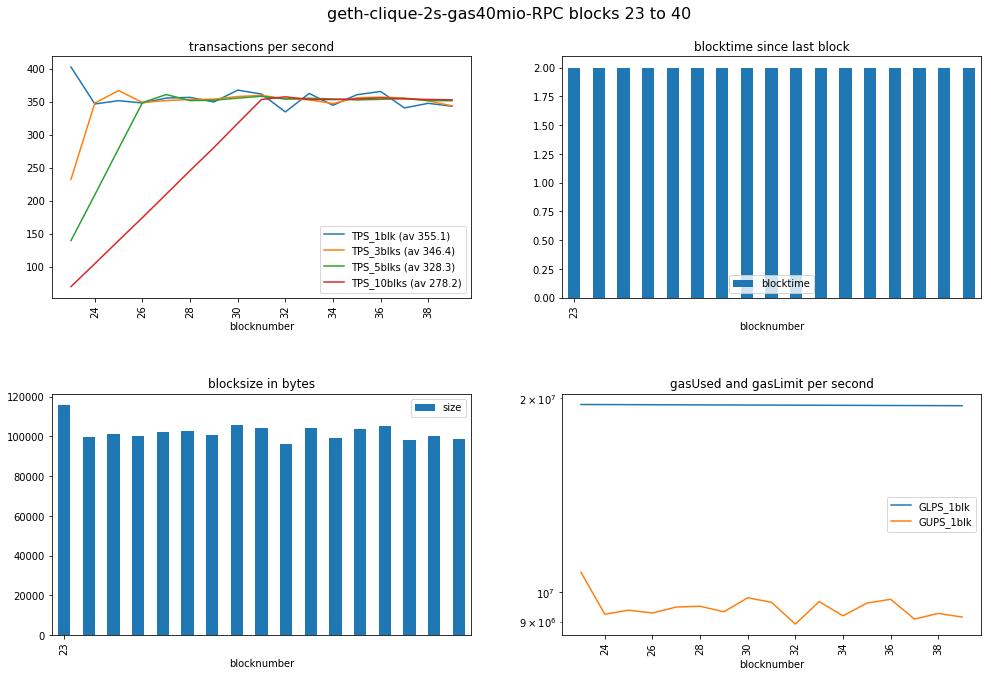

In [ ]:
diagrams(df, 23, 40, NAME_PREFIX, gas_logy=True, bt_logy=False)

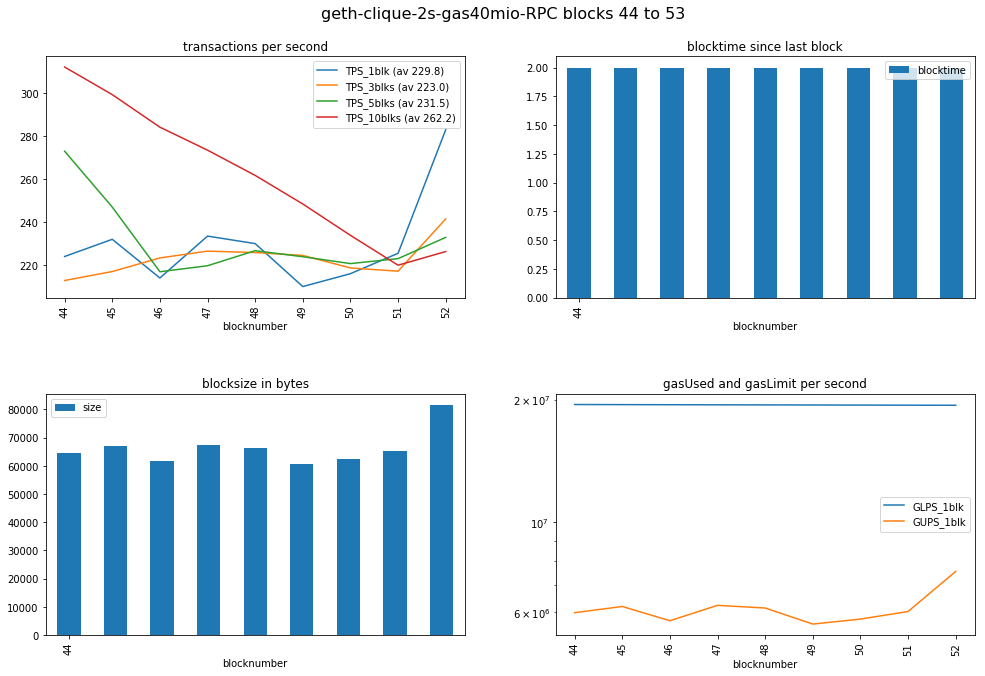

In [ ]:
diagrams(df, 44, 53, NAME_PREFIX, gas_logy=True, bt_logy=False)

In [ ]:
# what's wrong with the y-axis tick labels?

print (df["gasLimit"][44:52].mean())
print (df["gasUsed"][44:52].mean())

38823990.625
11910858.75


In [ ]:
df["size"][44:52].mean()

64420.125